In [1]:
import os
import json
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.sparse import coo_matrix, vstack

# Metrics obtained from an organizer of the Challenge
# https://github.com/plamere/RecsysChallengeTools/blob/master/metrics.py
from metrics import r_precision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
playlists = list()
tracks = dict()
map_pl = list()
map_pl_duplicate = list()
max_files_for_quick_processing = 40


def process_track(track):
    key = track['track_uri']
    if not key in tracks:
        tk = dict()
        tk['track_artist_name'] = track['artist_name']
        tk['track_artist_uri'] = track['artist_uri']
        tk['track_name'] = track['track_name']
        tk['track_album_uri'] = track['album_uri']
        tk['track_duration_ms'] = track['duration_ms']
        tk['track_album_name'] = track['album_name']
        tk['track_pos'] = track['pos']
        tracks[track['track_uri']] = tk
    return key


def process_playlist(playlist):
    pl = dict()
    pl['playlist_name'] = playlist['name']
    pl['playlist_collaborative'] = playlist['collaborative']
    pl['playlist_pid'] = playlist['pid']
    pl['playlist_modified_at'] = playlist['modified_at']
    pl['playlist_num_albums'] = playlist['num_albums']
    pl['playlist_num_tracks'] = playlist['num_tracks']
    pl['playlist_num_followers'] = playlist['num_followers']
    pl['playlist_num_edits'] = playlist['num_edits']
    pl['playlist_duration_ms'] = playlist['duration_ms']
    pl['playlist_num_artists'] = playlist['num_artists']
    if 'description' in playlist:
        pl['playlist_description'] = playlist['description']
    else:
        pl['playlist_description'] = ''
    trks = set()
    for track in playlist['tracks']:
        if track['track_uri'] not in trks:
            trks.add(track['track_uri'])
            process_track(track)
            map_pl.append([playlist['pid'], track['track_uri']])
        else:
            map_pl_duplicate.append([playlist['pid'], track['track_uri']])
    return pl

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            slice = json.loads(js)
            for playlist in slice['playlists']:
                playlists.append(process_playlist(playlist))
            count += 1
            if quick and count > max_files_for_quick_processing:
                break

                

quick = True
process_mpd('mpd.v1/data')

mpd.slice.0-999.json
mpd.slice.1000-1999.json
mpd.slice.10000-10999.json
mpd.slice.100000-100999.json
mpd.slice.101000-101999.json
mpd.slice.102000-102999.json
mpd.slice.103000-103999.json
mpd.slice.104000-104999.json
mpd.slice.105000-105999.json
mpd.slice.106000-106999.json
mpd.slice.107000-107999.json
mpd.slice.108000-108999.json
mpd.slice.109000-109999.json
mpd.slice.11000-11999.json
mpd.slice.110000-110999.json
mpd.slice.111000-111999.json
mpd.slice.112000-112999.json
mpd.slice.113000-113999.json
mpd.slice.114000-114999.json
mpd.slice.115000-115999.json
mpd.slice.116000-116999.json
mpd.slice.117000-117999.json
mpd.slice.118000-118999.json
mpd.slice.119000-119999.json
mpd.slice.12000-12999.json
mpd.slice.120000-120999.json
mpd.slice.121000-121999.json
mpd.slice.122000-122999.json
mpd.slice.123000-123999.json
mpd.slice.124000-124999.json
mpd.slice.125000-125999.json
mpd.slice.126000-126999.json
mpd.slice.127000-127999.json
mpd.slice.128000-128999.json
mpd.slice.129000-129999.json
mpd

In [7]:
print(len(playlists))
print(len(tracks))
print(len(map_pl))
print(len(map_pl_duplicate))

41000
406122
2716841


In [29]:
playlist_df = pd.DataFrame(playlists)
playlist_df.head()
# print(playlist_df.describe())

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
0,false,,11532414,1493424000,Throwbacks,47,37,6,1,52,0
1,false,,11656470,1506556800,Awesome Playlist,23,21,5,1,39,1
2,false,,14039958,1505692800,korean,51,31,18,1,64,2
3,false,,28926058,1501027200,mat,107,86,4,1,126,3
4,false,,4335282,1401667200,90s,16,16,7,2,17,4


In [30]:
tracks_df = pd.DataFrame.from_dict(tracks, orient='index')
tracks_df.head()
# print(tracks_df.describe())

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,track_pos
spotify:track:00039MgrmLoIzSpuYKurn9,Zach Farlow,spotify:artist:2jTojc4rAsOMx6200a8Ah1,Thas What I Do,spotify:album:0UHfgx3ITlxePDXLaN5Y6x,222727,The Great Escape 2,135
spotify:track:0007AYhg2UQbEm88mxu7js,Little Simz,spotify:artist:6eXZu6O7nAUA5z6vLV8NKI,Mandarin Oranges Part 2,spotify:album:32RJzqlapfiU0fr2l4SSW9,198000,E.D.G.E,34
spotify:track:000JBgYWfJQqdFaRqu2n3f,Joe Pass,spotify:artist:4DuZTASH5eSyd0K73W6fuZ,Li'l Darlin',spotify:album:2zm8AkHjOhwdvnj8NSVg6g,227626,Portrait,101
spotify:track:000VZqvXwT0YNqKk7iG2GS,The Ghost Inside,spotify:artist:6kQB2RN7WwryMdJ1MoQh1E,Mercy,spotify:album:75kQjmcR1YnIrBwVW1s4G1,256478,Dear Youth,23
spotify:track:000mA0etY38nKdvf1N04af,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,12


In [31]:
playlist_map_df = pd.DataFrame(map_pl, columns=['playlist_pid', 'track_uri'])
playlist_map_df.head()
#print(playlist_map_df.describe())

,playlist_pid,track_uri
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H


We set strings to lower case remove all non alphabetic characters and stop-words

In [32]:
import nltk
import string
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
ignored_words = [
    'music', 'songs', 'playlist', 'good', 'jams', 'mix', 'lit', 'best',
    'stuff', 'quot', 'like', 'one', 'amp', 'get', 'make', 'new', 'know',
    'really', 'back', 'day', 'days', 'little', 'things', 'great', 'everything',
    'jamz', 'tunes', 'artist', 'song', 'top', 'listen', 'favorite', 'bops',
    'description', 'top', 'ever', 'mostly', 'enjoy', 'bunch', 'track',
    'tracks', 'collection', 'need', 'every', 'favorites', 'may', 'got',
    'right', 'let', 'better', 'made'
]


def word_cleanup(df_col):
    df_col = df_col.apply(lambda x: x.lower())
    df_col = df_col.str.replace('[^a-z]+', ' ')
    df_col = df_col.apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if word not in (ignored_words)]))
    df_col = df_col.str.replace(r'\b\w{1,2}\b', '').str.replace(r'\s+', ' ')
    return df_col


playlist_df.playlist_description = word_cleanup(
    playlist_df.playlist_description)
playlist_df.playlist_name = word_cleanup(playlist_df.playlist_name)

#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: x.lower())
#playlist_df.playlist_name = playlist_df.playlist_name.str.replace('[^a-z]+', ' ')
#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

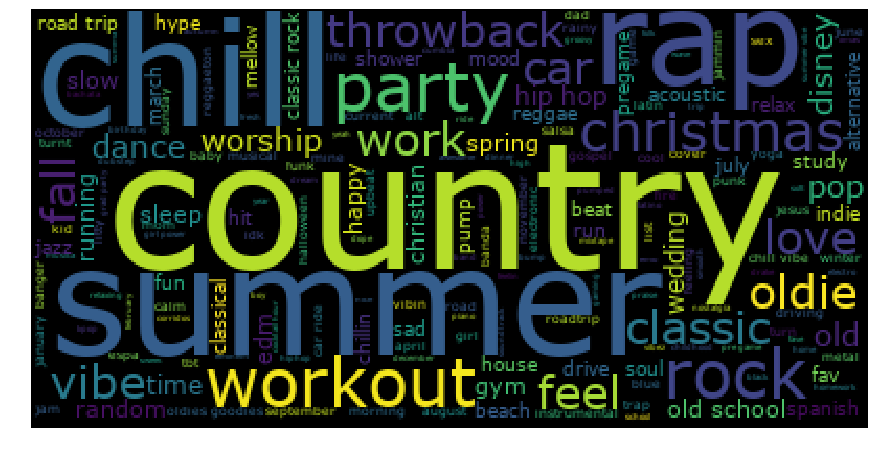

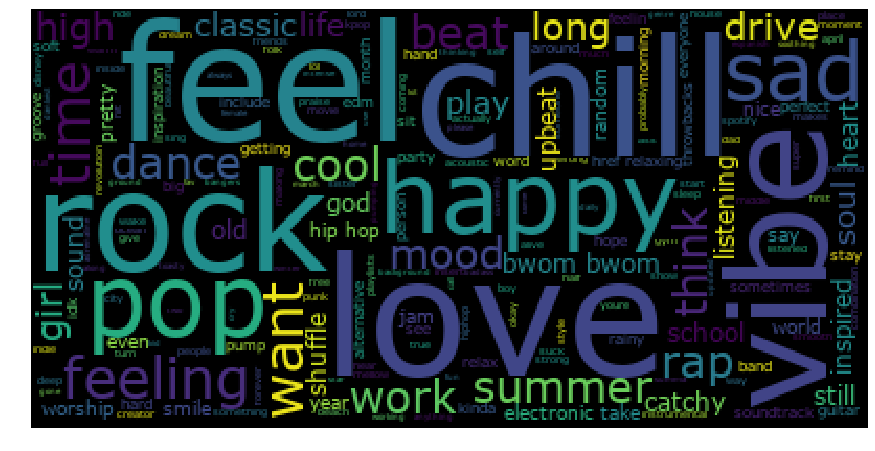

In [33]:
#pip install wordcloud
from wordcloud import WordCloud

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 0.1,
                          ).generate(text)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(' '.join(playlist_df.playlist_name))

generate_wordcloud(' '.join(playlist_df.playlist_description))

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv_description = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_description = cv_description.fit_transform(playlist_df.playlist_description)
playlist_df['playlist_description_frequency'] = list(dt_mat_description.toarray())

cv_name = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_name = cv_name.fit_transform(playlist_df.playlist_name)
playlist_df['playlist_name_frequency'] = list(dt_mat_name.toarray())

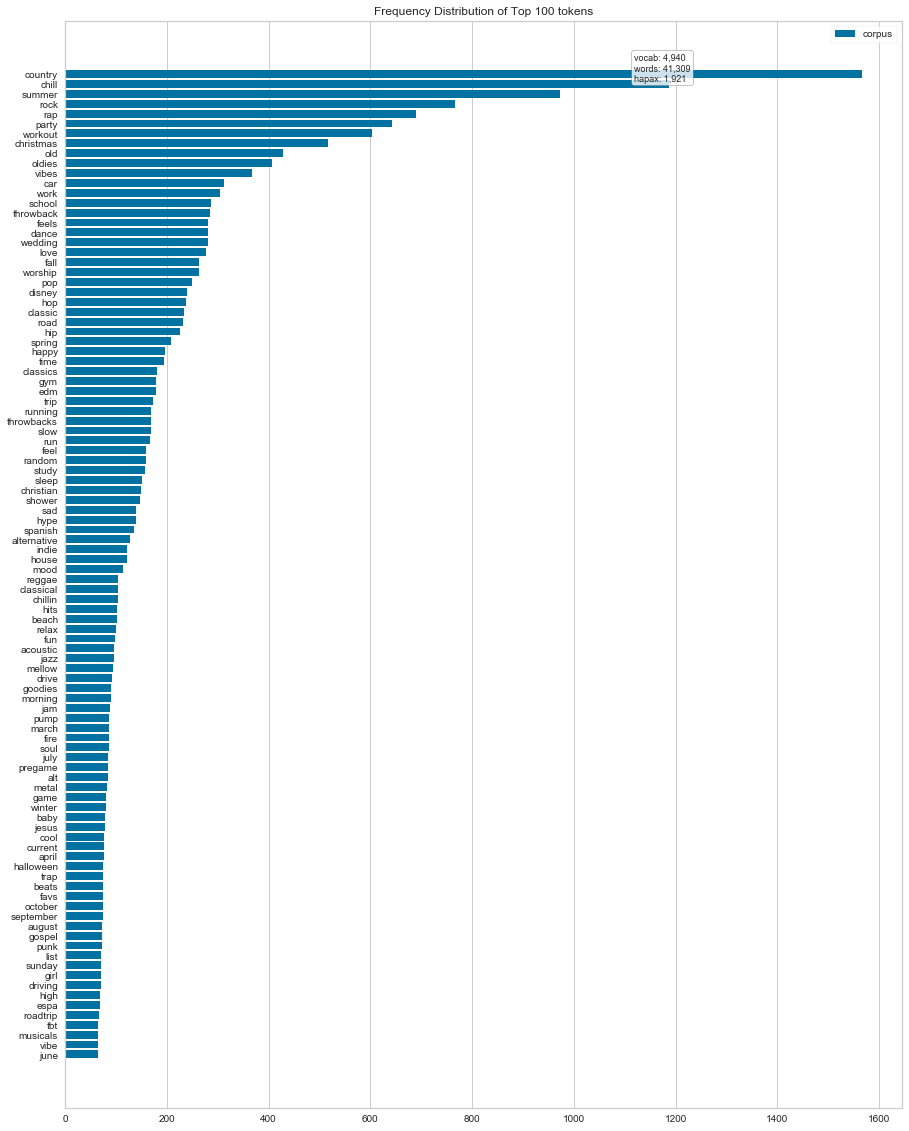

In [35]:
#pip install yellowbrick
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_name.get_feature_names())
visualizer.fit(dt_mat_name)
visualizer.poof()

In [36]:
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_description.get_feature_names())
#visualizer.fit(dt_mat_description)
#visualizer.poof()

<Figure size 1080x1440 with 0 Axes>

In [37]:
tfidf_transformer = TfidfTransformer()

tfidf_mat_description = tfidf_transformer.fit_transform(dt_mat_description)
playlist_df['playlist_description_tfidf_score']=list(tfidf_mat_description.toarray())

tfidf_mat_name = tfidf_transformer.fit_transform(dt_mat_name)
playlist_df['playlist_name_tfidf_score']=list(tfidf_mat_name.toarray())
playlist_df

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score
0,false,,11532414,1493424000,throwbacks,47,37,6,1,52,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,false,,11656470,1506556800,awesome,23,21,5,1,39,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,false,,14039958,1505692800,korean,51,31,18,1,64,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,false,,28926058,1501027200,mat,107,86,4,1,126,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,false,,4335282,1401667200,,16,16,7,2,17,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,false,,19156557,1430956800,wedding,71,56,3,1,80,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,false,,3408479,1477094400,put spell,15,13,2,1,16,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,false,,12674796,1509321600,,52,48,38,1,53,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,false,,9948921,1508976000,bop,37,23,21,2,46,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,false,,4297488,1501804800,old country,20,18,10,1,21,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [38]:
bigrams_name_frequency = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_frequency)

bigrams_desc_frequency = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_frequency)

bigrams_name_tfidf_score = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_tfidf_score)

bigrams_desc_tfidf_score = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_tfidf_score)

       aaa  aaaa  aaaaa  aaliyah  aaron  abba  abbey  abby  abc  abel  \
0        0     0      0        0      0     0      0     0    0     0   
1        0     0      0        0      0     0      0     0    0     0   
2        0     0      0        0      0     0      0     0    0     0   
3        0     0      0        0      0     0      0     0    0     0   
4        0     0      0        0      0     0      0     0    0     0   
5        0     0      0        0      0     0      0     0    0     0   
6        0     0      0        0      0     0      0     0    0     0   
7        0     0      0        0      0     0      0     0    0     0   
8        0     0      0        0      0     0      0     0    0     0   
9        0     0      0        0      0     0      0     0    0     0   
10       0     0      0        0      0     0      0     1    0     0   
11       0     0      0        0      0     0      0     0    0     0   
12       0     0      0        0      0     0      

       aaa  aaaa  aaaaa  aaliyah  aaron  abba  abbey  abby  abc  abel  \
0        0     0      0        0      0     0      0     0    0     0   
1        0     0      0        0      0     0      0     0    0     0   
2        0     0      0        0      0     0      0     0    0     0   
3        0     0      0        0      0     0      0     0    0     0   
4        0     0      0        0      0     0      0     0    0     0   
5        0     0      0        0      0     0      0     0    0     0   
6        0     0      0        0      0     0      0     0    0     0   
7        0     0      0        0      0     0      0     0    0     0   
8        0     0      0        0      0     0      0     0    0     0   
9        0     0      0        0      0     0      0     0    0     0   
10       0     0      0        0      0     0      0     1    0     0   
11       0     0      0        0      0     0      0     0    0     0   
12       0     0      0        0      0     0      

We generate the negative playlist by randomizing a mapping dataframe between songs and playlists

In [43]:
playlist_map_df_negative = playlist_map_df.copy()
random = playlist_map_df.sample(n=len(playlist_map_df)).reset_index()
playlist_map_df_negative['track_uri'] = random['track_uri']

In [44]:
# Create Negative Samples
negative_samples = pd.merge(
    pd.merge(
        tracks_df, playlist_map_df_negative, left_index=True, right_on='track_uri'),
    playlist_df,
    on='playlist_pid')

In [45]:
merged = pd.merge(
    pd.merge(
        tracks_df, playlist_map_df, left_index=True, right_on='track_uri'),
    playlist_df,
    on='playlist_pid')

In [46]:
# Provide labels
negative_samples['match'] = 0
merged['match'] = 1

In [ ]:
dataset = merged.append(negative_samples[merged.columns]).sort_values(by=['playlist_pid']).reset_index(drop=True)
dataset.loc[:,'playlist_pid'] = dataset.playlist_pid.astype(str)
dataset = dataset[list(tracks_df.columns)+['track_uri']+list(playlist_df.columns)+['match']]

In [ ]:
# Use for reading 40,000 playlist csv
###################################################################

dataset.drop(columns = ["playlist_description_frequency", "playlist_name_frequency"])

#These features need to be converted to strings after loading from csv file
to_str_features = ["playlist_pid", "track_artist_name", "track_name", 
                   "track_album_name", "playlist_description", "playlist_name"]

#Convert features to string type after loading csv
for feature in to_str_features:
    dataset[feature] = dataset.[feature].astype(str)

In [ ]:
# Include the features in the list below
# features = [
#     'playlist_duration_ms', 'playlist_num_albums', 'playlist_num_artists',
#     'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
#     'playlist_pid', 'track_duration_ms'
# ]
# data_x = dataset[features]
data_x = dataset.loc[:, dataset.columns != 'match']
data_y = dataset.match
data_train, data_test, y_train, y_test = train_test_split(
    data_x,
    data_y,
    test_size=0.1,
    # stratify=dataset.playlist_pid,
    stratify=dataset[['playlist_pid', 'match']],
    random_state=42,
    shuffle=True)

In [ ]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        # if self.key == 'playlist_pid': from IPython.core.debugger import set_trace; set_trace()
        return data_dict[:,[self.key]].astype(np.int64)

    def get_feature_names(self):
        return [dataset.columns[self.key]]

In [ ]:
# %%time

# we need a custom pre-processor to extract correct field,
# but want to also use default scikit-learn preprocessing (e.g. lowercasing)
default_preprocessor = CountVectorizer().build_preprocessor()


def build_preprocessor(field):
    field_idx = list(dataset.columns).index(field)
    # if field == 'playlist_pid': from IPython.core.debugger import set_trace; set_trace()
    return lambda x: default_preprocessor(x[field_idx])


vectorizer = FeatureUnion([
    (
        'track_artist_uri',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('track_artist_uri'))),
    (
        'track_album_uri',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('track_album_uri'))),
    (
        'track_uri',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('track_uri'))),

    (
        'playlist_pid',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('playlist_pid'))),

    ("playlist_name",
      CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r"(?u)\b\w+\b",
            stop_words=None,
            analyzer = 'word',
            # max_features=50000,
            preprocessor=build_preprocessor("playlist_name"))),
    
    ("playlist_description",
      CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r"(?u)\b\w+\b",
            stop_words=None,
            analyzer = 'word',
            # max_features=50000,
            preprocessor=build_preprocessor("playlist_description"))),
#     (
#         'track_pos',
#         CountVectorizer(
#             ngram_range=(1, 1),
#             token_pattern=r".+",
#             stop_words=None,
#             # max_features=50000,
#             preprocessor=build_preprocessor('track_pos'))),

    ('track_duration_ms',
     ItemSelector(list(dataset.columns).index('track_duration_ms'))),
])
X_train = vectorizer.fit_transform(data_train.values)

In [ ]:
data_train.shape

In [ ]:
X_test = vectorizer.transform(data_test.values)

In [ ]:
# Train the model
AdaModel = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                             n_estimators=100, learning_rate=0.05)
AdaModel = AdaModel.fit(X_train, y_train)
y_pred = AdaModel.predict(X_train)


In [ ]:
print(accuracy_score(y_train, y_pred))

In [ ]:
%%time
y_test_pred = AdaModel.predict(X_test)
print(accuracy_score(y_test, y_test_pred))

In [ ]:
print(data_test.shape)
print(X_test.shape)

In [ ]:
plt.rcParams["axes.facecolor"] = (1,1,.99) 
plt.rcParams["font.size"] = 15 
plt.rcParams["figure.figsize"] = (12,6) 
plt.rcParams["ytick.labelsize"] = 15 
plt.rcParams["xtick.labelsize"] = 15 
plt.rcParams["lines.linewidth"] = 2 
plt.rcParams["axes.titlesize"] = 20

#Histogram of probability predictions
probs = AdaModel.predict_proba(X_test)

fig, ax = plt.subplots(1,1, figsize = (12,6))
fig.suptitle("Histogram Shows How Model Assigns Probs to Match Likelihood", fontsize = 20)


ax.hist(probs[: ,1])
ax.set_title("Probs of Match")
ax.grid(alpha = 0)


In [ ]:
#Get important features and visual for features
#get top feature indices and ratings

importances = AdaModel.feature_importances_
indices = np.argsort(importances)[::-1]

top50index = []
top50importance = []
for f in range(50):
    top50index.append(indices[f])
    top50importance.append(importances[indices[f]])

In [ ]:
#helper in getting top features and making visual
#convert relevant dataframe columns to lowercase so we can compare with top feature output

track_artist_lower_df = tracks_df["track_artist_uri"].apply(lambda x: x.lower())
track_album_lower_df = tracks_df["track_album_uri"].apply(lambda x: x.lower())
merged_track_uri_lower_df = merged["track_uri"].apply(lambda x: x.lower())

#Take a uri and return album, artist or song title in plain english
def get_translation(uri_type, uri):
    
    track = False  #if a single track/song is input as uri, I need to handle it differently
    if uri_type == "track_artist_uri":
        df = track_artist_lower_df
        col = "track_artist_name"
    elif uri_type == "track_album_uri":
        df = track_album_lower_df
        col = "track_album_name"
    elif uri_type == "track_uri":
        df = merged_track_uri_lower_df
        col = "track_name"
        track = True   #Handle track_name differently by going to the merged df
    for i in range(len(tracks_df)):
        if df[i] == uri:
            if track == True:
                return merged.iloc[i][col]
            return tracks_df.iloc[i][col]
            break

In [ ]:
#Make list of top features
feature_names = []

#Loop through the indices of top features and append them to a list in plain english, not uri info
for i in top50index:
    feature = vectorizer.get_feature_names()[i].split("__")
    if feature[0] == "track_artist_uri":
        feature_names.append("Artist = " + get_translation("track_artist_uri", feature[1]))
    elif feature[0] == "track_album_uri":
        feature_names.append("Album = " + get_translation("track_album_uri", feature[1]))
    elif feature[0] == "track_uri":
        feature_names.append("Song = " + get_translation("track_uri", feature[1].lstrip()))
    
    else:
        feature_names.append(feature[0] + "_" + feature[1])

In [ ]:
#plot

fig, ax = plt.subplots(1,1, figsize = (20,15))
y_pos = np.arange(len(feature_names))
ax.barh(feature_names, top50importance, align = "center", color = "mediumspringgreen")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid(alpha = 0)
ax.set_xlabel("Importance", fontsize = 20)
ax.set_ylabel("Features", fontsize = 20)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=15)

fig.savefig("Feature Importance.png", bbox_inches="tight")

In [ ]:
#Check for relevant features besides playlist_pid numbers
not_pid_features = []
not_pid_importances = []
for feature in feature_names:
    if "playlist_pid" not in feature:
        not_pid_features.append(feature)
        idx = feature_names.index(feature)
        not_pid_importances.append(top50importance[idx])

In [ ]:
#plot important features except for playlist_pid
fig, ax = plt.subplots(1,1, figsize = (20,15))
y_pos = np.arange(len(not_pid_features) - 3)
ax.barh(not_pid_features[3:], not_pid_importances[3:], align = "center", color = "mediumspringgreen")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid(alpha = 0)
ax.set_xlabel("Importance", fontsize = 20)
ax.set_ylabel("Features", fontsize = 20)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=15)

fig.savefig("Feature Importance.png", bbox_inches="tight")

In [ ]:
#Can't do PCA on sparse matrix, use TruncatedSVD instead
from sklearn.decomposition import TruncatedSVD
pca_transformer = TruncatedSVD(2).fit(X_train) 
X_train_2d = pca_transformer.transform(X_train)
X_test_2d = pca_transformer.transform(X_test)

In [ ]:
colors = ['b', 'r']
label_text = ["Not Match", "Match"] 
plt.figure(figsize = (10,6))
for cur_quality in [0, 1]:
    cur_df = X_train_2d[y_train == cur_quality] 
    plt.scatter(
        cur_df[:, 0],
        cur_df[:, 1], 
        c=colors[cur_quality], 
        label=label_text[cur_quality])
plt.xlabel("PCA Dimension 1", fontsize = 13)
plt.ylabel("PCA Dimention 2", fontsize = 13)
plt.title("Scatter plots of top 2 PCA Components for Feature Data", fontsize = 15) 
plt.tick_params(labelsize = 13)
plt.grid(alpha = 0)
plt.legend();

In [ ]:
#train model on PCA, 2 components
model_2 = RandomForestClassifier().fit(X_train_2d, y_train)
model_2.score(X_test_2d, y_test)

In [ ]:
X_test_refined = pd.DataFrame([])
r_precisions = []
pbar = tqdm(data_test.groupby(['playlist_pid']))
for pid, df in pbar:
    p_info = df[playlist_df.columns].iloc[0]
    labels = y_test.loc[df.index]
    
    # Positive Tracks
    positive_tracks_idx = labels[labels == 1].index
    positive_tracks = data_test.loc[positive_tracks_idx]
    sp_positive_tracks = vectorizer.transform(positive_tracks.values)
    
    # Negative Tracks
    negative_tracks_idx = ~np.isin(data_test.index, positive_tracks_idx)
    negative_tracks = data_test[negative_tracks_idx].drop(
        playlist_df.columns, axis=1)
    negative_playlist = np.array([p_info.values] * len(negative_tracks))
    negative_playlist_samples = np.hstack([negative_tracks, negative_playlist])
    sp_negative_tracks = vectorizer.transform(negative_playlist_samples)
    
    # Test Tracks
    test_tracks = vstack([sp_negative_tracks, sp_positive_tracks])
    index_order = negative_tracks.index.append(positive_tracks_idx)
    
    # Predict, r_precision
    y_prob = AdaModel.predict_proba(test_tracks)
    # from IPython.core.debugger import set_trace; set_trace()
    y_pred = np.argsort(-y_prob[:,1])
    best_pred = index_order[y_pred]
    if len(positive_tracks_idx) > 0:
        r_precisions.append(r_precision(positive_tracks_idx, best_pred))
    pbar.set_description("{}".format(np.mean(r_precisions)))


In [ ]:
debug

In [ ]:
X_test_refined = pd.DataFrame([])
r_precisions = []
pbar = tqdm(data_test.groupby(['playlist_pid']))
for pid, df in pbar:
    labels = y_test.loc[df.index]
    from IPython.core.debugger import set_trace; set_trace()
    targets = dataset.loc[labels.index].track_duration_ms
    positive_targets = dataset.loc[labels[labels == 1].index].index
    # trained_idx = set(y_train[y_train == 1].index) - set(df.index)
    # Obtain all tracks from dataset which are not in the playlist under consideration
    #     negative_tracks = dataset.loc[X_train[(X_train.playlist_pid != pid)]
    #                                   .index].track_duration_ms
    negative_tracks = dataset.loc[X_test[(X_test.playlist_pid != pid)].index].track_duration_ms
    # trained_tracks = X_train.loc[y_train.loc[y_train[y_train==1].index].index].track_uri
    new_df = df.drop('track_duration_ms', axis=1)
    new_test = negative_tracks.append(targets)
    new_df = pd.concat([new_df.head(1)] * len(new_test))
    test_playlist_tracks = pd.concat(
        [new_df.reset_index(drop=True), new_test.reset_index(drop=True)],
        axis=1).set_index(new_test.index)
    # from IPython.core.debugger import set_trace; set_trace()
    test_playlist_tracks = (test_playlist_tracks-test_playlist_tracks.mean())/(test_playlist_tracks.std()+1e-8)
    X_test_refined = X_test_refined.append(test_playlist_tracks)
    y_prob = pd.DataFrame(
        lr_clf.predict_proba(test_playlist_tracks),
        index=test_playlist_tracks.index)
    y_prob = y_prob.sort_values(by=[1], ascending=False)
    if len(positive_targets) > 0:
        r_precisions.append(r_precision(positive_targets, y_prob.index))
    pbar.set_description("{}".format(np.mean(r_precisions)))
    # from IPython.core.debugger import set_trace; set_trace()

The dataset has been split, which is great. However, in order to better simulate real world situations, we need to build a test set with a lot more negative samples than there are positive samples. In the split above, there are equal number of positive and negative samples, so it'll be easy for the algorithm to perform. Below we build a more robust test set

In [ ]:
# 1. Calculate metric only on test set using the positive samples
#     a. Obtain unique playlists in the test set
#     b. For each playlist, obtain the positve songs.
#     c. Set both `target` and `prediction` as lists of the positive songs
#     d. For each playlist, calculate the r_precision. r_precision comes from the metrics.py file in the repo.

# 2. Train the X_train on the classifier. Obtain predictions for X_test

# 3. Repeat 1 above, now setting `predictions` as the list of songs "ranked by probability".

# 4. Calculate the r_precision metric based on your predicitons!

In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    probs = y_test.loc[df.index]  # change y_test to the output probs from clf
    targets = dataset.loc[probs[probs == 1].index].track_uri
    predictions = dataset.loc[probs[probs > 0.5].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

In [ ]:
X_train_norm = (X_train-X_train.mean())/X_train.std()
X_test_norm = (X_test-X_test.mean())/X_test.std()

In [ ]:
X_train_norm.head()

In [ ]:
X_test_norm.head()

In [ ]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(X_train_norm, y_train)

In [ ]:
# y_prob = lr_clf.predict_proba(X_test)
y_prob = pd.DataFrame(lr_clf.predict_proba(X_test_norm), index=y_test.index)

In [ ]:
y_prob.head(10)

In [ ]:
y_test.head(10)

In [ ]:
y_pred = y_prob.idxmax(axis=1)

In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    labels = y_test.loc[df.index]  # change y_test to the output probs from clf
    preds = y_pred.loc[df.index]
    targets = dataset.loc[labels[labels == 1].index].track_uri
    predictions = dataset.loc[preds[preds == 1].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

In [ ]:
X_test_refined = pd.DataFrame([])
r_precisions = []
pbar = tqdm(data_test.groupby(['playlist_pid']))
for pid, df in pbar:
    labels = y_test.loc[df.index]
    targets = dataset.loc[labels.index].track_duration_ms
    positive_targets = dataset.loc[labels[labels == 1].index].index
    # trained_idx = set(y_train[y_train == 1].index) - set(df.index)
    # Obtain all tracks from dataset which are not in the playlist under consideration
    #     negative_tracks = dataset.loc[X_train[(X_train.playlist_pid != pid)]
    #                                   .index].track_duration_ms
    negative_tracks = dataset.loc[X_test[(X_test.playlist_pid != pid)]
                                  .index].track_duration_ms
    # trained_tracks = X_train.loc[y_train.loc[y_train[y_train==1].index].index].track_uri
    new_df = df.drop('track_duration_ms', axis=1)
    new_test = negative_tracks.append(targets)
    new_df = pd.concat([new_df.head(1)] * len(new_test))
    test_playlist_tracks = pd.concat(
        [new_df.reset_index(drop=True), new_test.reset_index(drop=True)],
        axis=1).set_index(new_test.index)
    # from IPython.core.debugger import set_trace; set_trace()
    test_playlist_tracks = (test_playlist_tracks-test_playlist_tracks.mean())/(test_playlist_tracks.std()+1e-8)
    X_test_refined = X_test_refined.append(test_playlist_tracks)
    y_prob = pd.DataFrame(
        lr_clf.predict_proba(test_playlist_tracks),
        index=test_playlist_tracks.index)
    y_prob = y_prob.sort_values(by=[1], ascending=False)
    if len(positive_targets) > 0:
        r_precisions.append(r_precision(positive_targets, y_prob.index))
    pbar.set_description("{}".format(np.mean(r_precisions)))
    # from IPython.core.debugger import set_trace; set_trace()

In [ ]:
np.unique(r_precisions, return_counts=True)

In [ ]:
np.mean(r_precisions)

Question: Do playlist and track duration interact to influence whether a song should belong to a playlist `(match=1)` or whether a song should not belong to a playlist `(match=0)`?

In [ ]:
(dataset[dataset.match==1].playlist_duration_ms/dataset[dataset.match==1].playlist_num_tracks)

In [ ]:
plt.scatter(dataset[dataset.match == 1].playlist_duration_ms /
            dataset[dataset.match == 1].playlist_num_tracks,
            dataset[dataset.match == 1].track_duration_ms)
plt.scatter(dataset[dataset.match == 0].playlist_duration_ms /
            dataset[dataset.match == 0].playlist_num_tracks,
            dataset[dataset.match == 0].track_duration_ms)
plt.xlabel('Average Track Duration')
plt.ylabel('Track Duration')


A trend which might not be that strong to notice is that as the average track duration increases for a playlist, the propensity to see a track of long duration increases. However, this isn't the case with negative sample playlists, where in playlist of short length very long tracks can still be detected.

In [ ]:
plt.hist(dataset[dataset.match==1].playlist_duration_ms)
plt.hist(dataset[dataset.match==0].playlist_duration_ms)

https://stackoverflow.com/questions/49018652/how-to-combine-labelbinarizer-and-onehotencoder-in-pipeline-in-python-for-catego 
